In [47]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
import struct
import pandas
from pysofia import svm_train, svm_predict, learner_type, loop_type, eta_type
from scipy import stats
from skimage.measure import shannon_entropy
from skimage.filters import threshold_otsu
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [16, 16]

In [48]:
subclavia = np.load("/home/sean/Documents/Development/deep_light_field_interp/res/subclavia.npy")
mri_front = np.load("/home/sean/Documents/Development/deep_light_field_interp/res/mriheadfront.npy")
mri_top = np.load("/home/sean/Documents/Development/deep_light_field_interp/res/mriheadtop.npy")
mri_side = np.load("/home/sean/Documents/Development/deep_light_field_interp/res/mriheadside.npy")

In [49]:
def calculate_entropy_values(slices):
    results = np.zeros(slices.shape[0])

    for i in range(len(slices)):
        thresh = np.mean(slices[i])
#         thresh = 128
        mri_slice = np.squeeze(slices[i, :, :])
    #     binary_image = mri_slice // 64
    #     binary_image = mri_slice * 64
        value = shannon_entropy(mri_slice)
        if not np.isinf(value):
            results[i] = value
    
    return results

In [50]:
entropy_subclavia = calculate_entropy_values(subclavia)
entropy_top = calculate_entropy_values(mri_top)
entropy_side = calculate_entropy_values(mri_side)
entropy_front = calculate_entropy_values(mri_front)

order_subclavia = np.arange(96, dtype=np.float)
order_top = np.arange(256, dtype=np.float)
order_side = np.arange(256, dtype=np.float)
order_front = np.arange(256, dtype=np.float)

In [51]:
def get_rank_rep(X, y):
    X_ordered = np.empty(X.shape, dtype=np.float32)
    
    timesteps = len(y)
    
    for idx in range(timesteps):
        y_min = np.min(y)
        y_arg_min = np.argmin(y)
        
        X_ordered[idx] = X[y_arg_min]
        
        y[np.where(y == y_min)] = np.infty
    
    alpha = np.zeros((timesteps, 1, 1), dtype=np.float32)
    
    for t in range(1, timesteps + 1):
        idx = t - 1
        alpha[idx] = (2 * t) - timesteps - 1
        
    X_ordered *= alpha
    X_ordered = np.sum(X_ordered, axis=0)
    
    return X_ordered

In [52]:
def get_rank_image(data, orders, img_size):
    rep = get_rank_rep(data, orders)
    rep = np.reshape(rep, img_size)
    return rep

In [53]:
def save_inc_reps(X, y, filename, img_size):
    num_reps = X.shape[0] // 16
    reps = np.zeros((num_reps, img_size[0], img_size[1]), dtype=np.float32)
    for i in range(num_reps):
        rep = get_rank_image(
            X[i * num_reps: (i*num_reps) + num_reps],  
            y[i * num_reps: ((i*num_reps) + num_reps)], 
            img_size
        )
        scaler = MinMaxScaler(feature_range=(-1, +1))
        scaler.fit(rep)
        reps[i] = np.float32(scaler.transform(rep))
    np.save(filename, reps)

In [54]:
subclavia_rep = get_rank_image(subclavia, entropy_subclavia, (512, 512))
front_rep = get_rank_image(mri_front, entropy_front, (256, 256))
side_rep = get_rank_image(mri_side, entropy_side, (256, 256))
top_rep = get_rank_image(mri_top, entropy_top, (256, 256))

In [55]:
def plot_rank_image(rank_image):
    scaler = MinMaxScaler(feature_range=(-1, +1))
    scaler.fit(rank_image)
    plt.imshow(scaler.transform(rank_image))

In [56]:
def make_image(data, outputname, size=(1, 1), dpi=80):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('hot')
    ax.imshow(data, aspect='equal')
    plt.savefig(outputname, dpi=dpi)

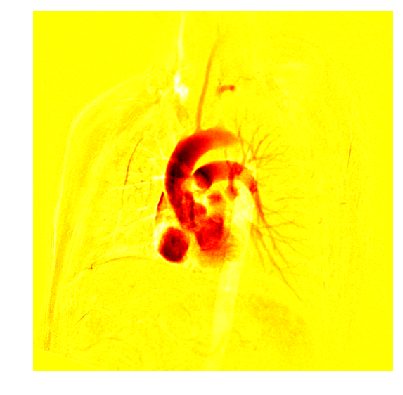

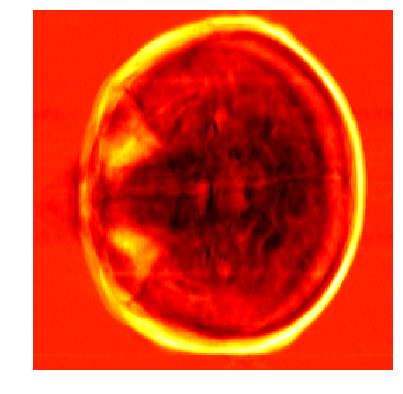

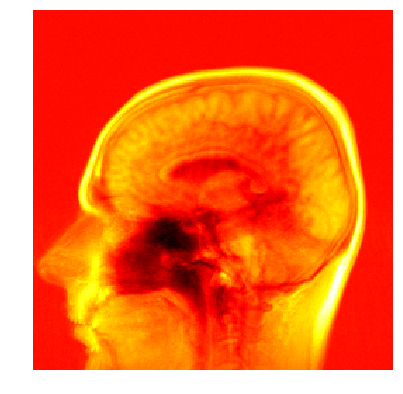

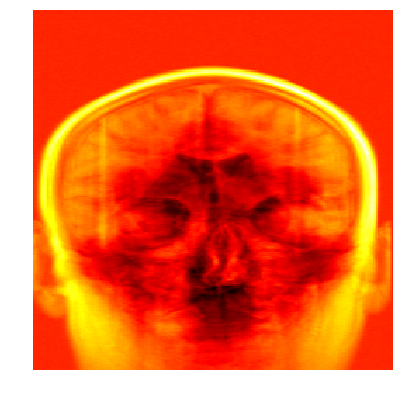

In [57]:
make_image(subclavia_rep, 'subclavia_entropy_approx.png', (5, 5))
make_image(top_rep, 'toprep_entropy_approx.png', (5, 5))
make_image(side_rep, 'siderep_entropy_approx.png', (5, 5))
make_image(front_rep, 'fontrep_entropy_approx.png', (5, 5))

In [58]:
subclavia_rep_order = get_rank_image(subclavia, order_subclavia, (512, 512))
front_rep_order = get_rank_image(mri_front, order_front, (256, 256))
side_rep_order = get_rank_image(mri_side, order_side, (256, 256))
top_rep_order = get_rank_image(mri_top, order_top, (256, 256))

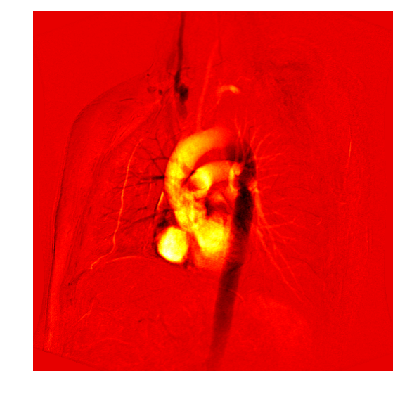

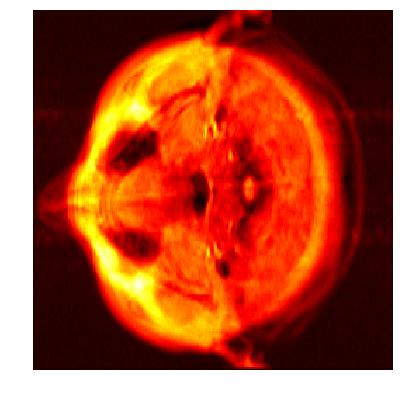

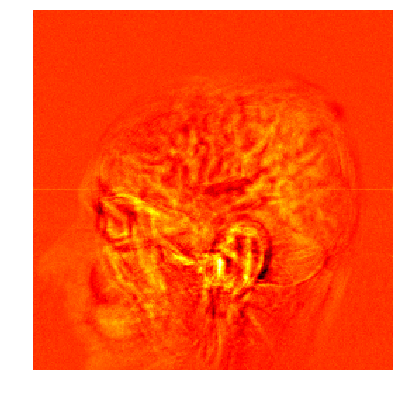

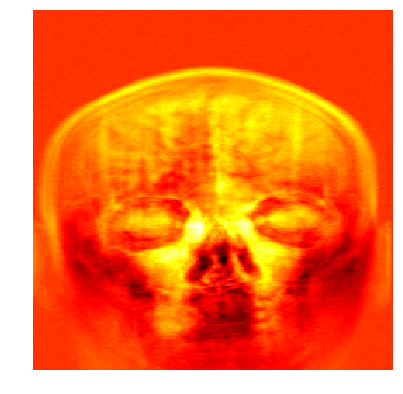

In [59]:
make_image(subclavia_rep_order, 'subclavia_order_approx.png', (5, 5))
make_image(top_rep_order, 'toprep_order_approx.png', (5, 5))
make_image(side_rep_order, 'siderep_order_approx.png', (5, 5))
make_image(front_rep_order, 'fontrep_order_approx.png', (5, 5))

In [60]:
save_inc_reps(subclavia, entropy_subclavia, "inc_reps_subclavia_entropy_approx.npy", (512, 512))
save_inc_reps(mri_front, entropy_front, "inc_reps_front_entropy_approx.npy", (256, 256))
save_inc_reps(mri_top, entropy_top, "inc_reps_top_entropy_approx.npy", (256, 256))
save_inc_reps(mri_side, entropy_side, "inc_reps_side_entropy_approx.npy", (256, 256))

save_inc_reps(subclavia, order_subclavia, "inc_reps_subclavia_order_approx.npy", (512, 512))
save_inc_reps(mri_front, order_front, "inc_reps_front_order_approx.npy", (256, 256))
save_inc_reps(mri_top, order_top, "inc_reps_top_order_approx.npy", (256, 256))
save_inc_reps(mri_side, order_side, "inc_reps_side_order_approx.npy", (256, 256))